In [1]:
from prod.set_seed import random_ctl
seed = random_ctl(432286)

from fastai.text import *
from fastai.callbacks import SaveModelCallback
from fastai.layers import LabelSmoothingCrossEntropy

import sentencepiece as spm #https://github.com/google/sentencepiece
import fire

from sp_tok import *
from prod.bin_metrics import Fbeta_binary
from sklearn.model_selection import KFold

def split_rebal_data_by_idx(all_texts_df:DataFrame, train_idx, valid_idx,
                            clas_col:str='is_humor'):
    ## rebalance cases
    print('Number of positive samples:', (all_texts_df.loc[:,clas_col] == 1).sum())
    print('Number of negative samples:',  (all_texts_df.loc[:,clas_col] == 0).sum())
    print('Total samples:', len(all_texts_df))

    df_train_all = all_texts_df.iloc[train_idx,:]
    df_valid     = all_texts_df.iloc[valid_idx,:]

    print('Valid prevalence(n = %d):'%len(df_valid),df_valid.loc[:,clas_col].sum()/ len(df_valid))
    print('Train all prevalence(n = %d):'%len(df_train_all), df_train_all.loc[:,clas_col].sum()/ len(df_train_all))
    print('all samples (n = %d)'%len(all_texts_df))
    assert len(all_texts_df) == (len(df_valid)+len(df_train_all)),'math didnt work'

    ## assumes that negative is less frequent case.  Generalize?
    rows_pos = df_train_all.loc[:,clas_col] == 1
    df_train_pos = df_train_all.loc[rows_pos]
    df_train_neg = df_train_all.loc[~rows_pos]
    print(f'Train Pos Cases:{df_train_pos.shape},Train Neg Cases:{df_train_neg.shape}')
    df_resample_pos = df_train_pos.sample(n=len(df_train_neg),replace=True,
                                          axis=0,random_state=np.random.get_state()[1][0]).reset_index(drop=True)
    df_train = pd.concat([df_resample_pos,df_train_neg],axis=0) #randomized again in DataBunch?
    print('Train prevalence (n = %d):'%len(df_train), df_train.loc[:,clas_col].sum()/ len(df_train))

    return df_train, df_valid
        

Using seed: 432286


In [2]:
model_path:str='./data/rnn/'
sp_model:str='./all_tweets_es_0609'
flat_loss:bool=True
qrnn:bool=True
n_hid:int=2304 
load_enc:str='twitter_es_enc_QRNN_0609_drop1_seed0_finetune'
split_seed:int=20190303
backward:bool=False
wd:float=0.1

In [3]:
# create midxup loss, modify current loss
# create mixup callback
  # mixup after embedding layer
#process as ususal

In [4]:
"Implements [mixup](https://arxiv.org/abs/1710.09412) training method"
from fastai.torch_core import *
from fastai.callback import *
from fastai.basic_train import Learner, LearnerCallback

# def mixup(learn:Learner, alpha:float=0.4, stack_x:bool=False, stack_y:bool=True) -> Learner:                                             
#     "Add mixup https://arxiv.org/abs/1710.09412 to `learn`."                                                                             
#     learn.callback_fns.append(partial(MixUpCallback, alpha=alpha, stack_x=stack_x, stack_y=stack_y))                                     
#     return learn

class NLP_MixUpCallback(LearnerCallback):
    "Callback that creates the mixed-up input and target."
    def __init__(self, learn:Learner, alpha:float=0.4, stack_x:bool=False, stack_y:bool=True):
        super().__init__(learn)
        self.alpha,self.stack_x,self.stack_y = alpha,stack_x,stack_y
    
    def on_train_begin(self, **kwargs):
        if self.stack_y: self.learn.loss_func = MixUpLoss(self.learn.loss_func)
        
    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        "Applies mixup to `last_input` and `last_target` if `train`."
        '''
        append relevant data to forward pass and handle in forward pass to generate mixup batch
        '''
        if not train: return
        lambd = np.random.beta(self.alpha, self.alpha, last_target.size(0))
        lambd = np.concatenate([lambd[:,None], 1-lambd[:,None]], 1).max(1)
        lambd = last_input.float().new(lambd)
        shuffle = torch.randperm(last_target.size(0)).to(last_input.device)
        y1 = last_target[shuffle]
        if self.stack_x: pass
        else:
            new_input = {0:last_input, 1:shuffle, 2:lambd}
        if self.stack_y:
            new_target = torch.cat([last_target[:,None].float(), y1[:,None].float(), lambd[:,None].float()], 1)
#             new_target = last_target ## for reference with no shuffle!
        return {'last_input': new_input, 'last_target': new_target}  
    
    def on_train_end(self, **kwargs):
        if self.stack_y: self.learn.loss_func = self.learn.loss_func.get_old()
        

class MixUpLoss(nn.Module):
    "Adapt the loss function `crit` to go with mixup."
    
    def __init__(self, crit, reduction='mean'):
        super().__init__()
        if hasattr(crit, 'reduction'): 
            self.crit = crit
            self.old_red = crit.reduction
            setattr(self.crit, 'reduction', 'none')
        else: 
            self.crit = partial(crit, reduction='none')
            self.old_crit = crit
        self.reduction = reduction
        
    def forward(self, output, target):
        if len(target.size()) == 2:
            #loss on original batch, loss on mixup batch
            loss1, loss2 = self.crit(output,target[:,0].long()), self.crit(output,target[:,1].long())
            #weighted by the mixup lambda for each sample.
            d = (loss1 * target[:,2] + loss2 * (1-target[:,2])).mean()
        else:  d = self.crit(output, target)
        if self.reduction == 'mean': return d.mean()
        elif self.reduction == 'sum': return d.sum()
        return d
    
    def get_old(self):
        if hasattr(self, 'old_crit'):  return self.old_crit
        elif hasattr(self, 'old_red'): 
            setattr(self.crit, 'reduction', self.old_red)
            return self.crit

In [5]:
class AWD_LSTM_mixup(nn.Module):
    "AWD-LSTM/QRNN inspired by https://arxiv.org/abs/1708.02182."
    "allows mixup on inputs"

    initrange=0.1

    def __init__(self, vocab_sz:int, emb_sz:int, n_hid:int, n_layers:int, pad_token:int=1, hidden_p:float=0.2,
                 input_p:float=0.6, embed_p:float=0.1, weight_p:float=0.5, qrnn:bool=False, bidir:bool=False,
                mixup:bool=False):
        super().__init__()
        self.bs,self.qrnn,self.emb_sz,self.n_hid,self.n_layers = 1,qrnn,emb_sz,n_hid,n_layers
        self.mixup = mixup
        self.n_dir = 2 if bidir else 1
        self.encoder = nn.Embedding(vocab_sz, emb_sz, padding_idx=pad_token)
        self.encoder_dp = EmbeddingDropout(self.encoder, embed_p)
        if self.qrnn:
            #Using QRNN requires an installation of cuda
            from fastai.text.models.qrnn import QRNN
            self.rnns = [QRNN(emb_sz if l == 0 else n_hid, (n_hid if l != n_layers - 1 else emb_sz)//self.n_dir, 1,
                              save_prev_x=True, zoneout=0, window=2 if l == 0 else 1, output_gate=True, bidirectional=bidir) 
                         for l in range(n_layers)]
            for rnn in self.rnns: 
                rnn.layers[0].linear = WeightDropout(rnn.layers[0].linear, weight_p, layer_names=['weight'])
        else:
            self.rnns = [nn.LSTM(emb_sz if l == 0 else n_hid, (n_hid if l != n_layers - 1 else emb_sz)//self.n_dir, 1,
                                 batch_first=True, bidirectional=bidir) for l in range(n_layers)]
            self.rnns = [WeightDropout(rnn, weight_p) for rnn in self.rnns]
        self.rnns = nn.ModuleList(self.rnns)
        self.encoder.weight.data.uniform_(-self.initrange, self.initrange)
        self.input_dp = RNNDropout(input_p)
        self.hidden_dps = nn.ModuleList([RNNDropout(hidden_p) for l in range(n_layers)])

    def forward(self, input, shuffle, lambd, from_embeddings:bool=False)->Tuple[Tensor,Tensor]:
        if from_embeddings: bs,sl,es = input.size()
        else: bs,sl = input.size()
        if bs!=self.bs:
            self.bs=bs
            self.reset()
        post_emb = input if from_embeddings else self.encoder_dp(input)
        ## add mixup here for this batch.
        if self.mixup and self.training:
#             new_input = (last_input * lambd.view(lambd.size(0),1,1,1) + x1 * (1-lambd).view(lambd.size(0),1,1,1))            
            x1_post_emb = input if from_embeddings else self.encoder_dp(input[shuffle])
            post_emb = post_emb*lambd.view(lambd.size(0),1,1) + x1_post_emb*(1.-lambd).view(lambd.size(0),1,1)
        raw_output = self.input_dp(post_emb)
        new_hidden,raw_outputs,outputs = [],[],[]
        for l, (rnn,hid_dp) in enumerate(zip(self.rnns, self.hidden_dps)):
            raw_output, new_h = rnn(raw_output, self.hidden[l])
            new_hidden.append(new_h)
            raw_outputs.append(raw_output)
            if l != self.n_layers - 1: raw_output = hid_dp(raw_output)
            outputs.append(raw_output)
        self.hidden = to_detach(new_hidden, cpu=False)
        return raw_outputs, outputs

    def _one_hidden(self, l:int)->Tensor:
        "Return one hidden state."
        nh = (self.n_hid if l != self.n_layers - 1 else self.emb_sz) // self.n_dir
        return one_param(self).new(self.n_dir, self.bs, nh).zero_()

    def select_hidden(self, idxs):
        if self.qrnn: self.hidden = [h[:,idxs,:] for h in self.hidden]
        else: self.hidden = [(h[0][:,idxs,:],h[1][:,idxs,:]) for h in self.hidden]
        self.bs = len(idxs)

    def reset(self):
        "Reset the hidden states."
        [r.reset() for r in self.rnns if hasattr(r, 'reset')]
        if self.qrnn: self.hidden = [self._one_hidden(l) for l in range(self.n_layers)]
        else: self.hidden = [(self._one_hidden(l), self._one_hidden(l)) for l in range(self.n_layers)]

            
class m_MultiBatchEncoder(nn.Module):                                                                                                       
    "Create an encoder over `module` that can process a full sentence."                                                                   
    def __init__(self, bptt:int, max_len:int, module:nn.Module, pad_idx:int=1):                                                           
        super().__init__()                                                                                                                
        self.max_len,self.bptt,self.module,self.pad_idx = max_len,bptt,module,pad_idx                                                     
                                                                                                                                          
    def concat(self, arrs:Collection[Tensor])->Tensor:                                                                                    
        "Concatenate the `arrs` along the batch dimension."                                                                               
        return [torch.cat([l[si] for l in arrs], dim=1) for si in range_of(arrs[0])]                                                      

    def reset(self):                                                                                                                      
        if hasattr(self.module, 'reset'): self.module.reset()                                                                             
                                                                                                                                          
    def forward(self, mix_input:Dict)->Tuple[Tensor,Tensor]:
        if isinstance(mix_input,dict):
            input, shuffle, lambd = mix_input[0], mix_input[1], mix_input[2] #unpack mixup input to get splits, shuffle 
        else: input,shuffle,lambd = mix_input,None,None
        bs,sl = input.size()
        self.reset()
        raw_outputs,outputs,masks = [],[],[]                    
        for i in range(0, sl, self.bptt):                       
            r, o = self.module(input[:,i: min(i+self.bptt, sl)],shuffle,lambd)
            if i>(sl-self.max_len):
                masks.append(input[:,i: min(i+self.bptt, sl)] == self.pad_idx)
                raw_outputs.append(r)                                         
                outputs.append(o)                                             
        return self.concat(raw_outputs),self.concat(outputs),torch.cat(masks,dim=1)            

In [6]:
_model_meta = {AWD_LSTM_mixup: {'hid_name':'emb_sz', 'url':URLs.WT103_1,                                                                        
                          'config_lm':awd_lstm_lm_config, 'split_lm': awd_lstm_lm_split,                                                  
                          'config_clas':awd_lstm_clas_config, 'split_clas': awd_lstm_clas_split}}

def get_text_classifier(arch:Callable, vocab_sz:int, n_class:int, bptt:int=70, max_len:int=20*70, config:dict=None, 
                        drop_mult:float=1., lin_ftrs:Collection[int]=None, ps:Collection[float]=None,
                        pad_idx:int=1) -> nn.Module:
    "Create a text classifier from `arch` and its `config`, maybe `pretrained`."
    meta = _model_meta[arch]
    config = ifnone(config, meta['config_clas']).copy()
    for k in config.keys(): 
        if k.endswith('_p'): config[k] *= drop_mult
    if lin_ftrs is None: lin_ftrs = [50]
    if ps is None:  ps = [0.1]*len(lin_ftrs)
    layers = [config[meta['hid_name']] * 3] + lin_ftrs + [n_class]
    ps = [config.pop('output_p')] + ps
    init = config.pop('init') if 'init' in config else None
    encoder = m_MultiBatchEncoder(bptt, max_len, arch(vocab_sz, **config), pad_idx=pad_idx)
    model = SequentialRNN(encoder, PoolingLinearClassifier(layers, ps))
    return model if init is None else model.apply(init)

def text_classifier_learner(data:DataBunch, arch:Callable, bptt:int=70, max_len:int=70*20, config:dict=None, 
                            pretrained:bool=True, drop_mult:float=1., lin_ftrs:Collection[int]=None, 
                            ps:Collection[float]=None, **learn_kwargs) -> 'TextClassifierLearner':
    "Create a `Learner` with a text classifier from `data` and `arch`."
    model = get_text_classifier(arch, len(data.vocab.itos), data.c, bptt=bptt, max_len=max_len,
                                config=config, drop_mult=drop_mult, lin_ftrs=lin_ftrs, ps=ps)
    meta = _model_meta[arch]
    learn = RNNLearner(data, model, split_func=meta['split_clas'], **learn_kwargs)
    if pretrained:
        if 'url' not in meta: 
            warn("There are no pretrained weights for that architecture yet!")
            return learn
        model_path = untar_data(meta['url'], data=False)
        fnames = [list(model_path.glob(f'*.{ext}'))[0] for ext in ['pth', 'pkl']]
        learn.load_pretrained(*fnames, strict=False)
        learn.freeze()
    return learn

In [7]:
PATH = Path(model_path)
# torch.backends.cudnn.enabled=False

defaults.text_spec_tok.append(NL) #add a New Line special char
sp_vocab = Vocab( get_itos(sp_model) )
mycust_tok = CustomTokenizer(SPTokenizer, sp_model, pre_rules=default_rules)

all_texts_df = pd.read_csv('./data/haha_2019_train.csv')
raw_text = all_texts_df.loc[:,'text']

print("Default Rules:\n",[x.__name__ for x in default_rules],"\n\n")
for rule in default_rules: raw_text = raw_text.apply(lambda x: rule(str(x)))
all_texts_df['new_text'] = raw_text #databunch adds `xxbos` so don't add here

kfolder = KFold(n_splits=5, random_state=split_seed, shuffle=True)
for n_fold, (train_idx,valid_idx) in enumerate(kfolder.split(all_texts_df)):
    print(f'Kfold: {n_fold} of 5')
    df_train,df_valid = split_rebal_data_by_idx(all_texts_df,train_idx,valid_idx,clas_col='is_humor')    
    data = TextClasDataBunch.from_df(PATH,df_train,df_valid,
                                   tokenizer=mycust_tok, vocab=sp_vocab,
                                     text_cols='new_text', label_cols='is_humor', backwards=backward)
    config = awd_lstm_clas_config.copy()
    config['qrnn'] = qrnn
    config['n_hid'] = n_hid
    config['mixup'] = True
    print(config)
    learn = text_classifier_learner(data, AWD_LSTM_mixup, drop_mult=0.7,pretrained=False,config=config)
    learn.metrics += [Fbeta_binary(beta2=1,clas=1)]
    if load_enc : learn.load_encoder(load_enc)
    if flat_loss: learn.loss_func = FlattenedLoss(LabelSmoothingCrossEntropy)
    break 

{'emb_sz': 400, 'n_hid': 2304, 'n_layers': 3, 'pad_token': 1, 'qrnn': True, 'bidir': False, 'output_p': 0.4, 'hidden_p': 0.3, 'input_p': 0.4, 'embed_p': 0.05, 'weight_p': 0.5, 'mixup': True}


In [8]:
learn.callback_fns.append(partial(NLP_MixUpCallback,alpha=0.4,stack_x=False,stack_y=True))

In [9]:
learn.fit_one_cycle(2, 1e-2, wd=wd )

epoch,train_loss,valid_loss,accuracy,fbeta_binary,time
0,0.628058,0.464729,0.837083,0.793012,00:08
1,0.590297,0.471435,0.815833,0.785541,00:09


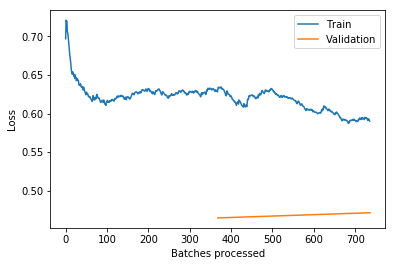

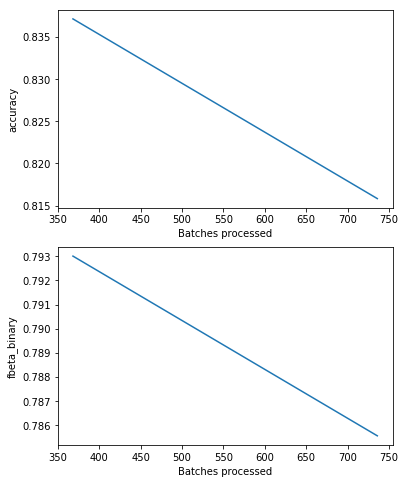

In [10]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(15, slice(1e-3/(2.6**4),5e-3), moms=(0.7,0.4), wd=wd, pct_start=0.25, div_factor=8.,
                    callbacks=[SaveModelCallback(learn,every='improvement',mode='max',
                                                 monitor='fbeta_binary',name=f'best_acc_model_Q_{seed}')])
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

epoch,train_loss,valid_loss,accuracy,fbeta_binary,time
0,0.576456,0.453590,0.824583,0.792815,00:19
1,0.572767,0.433562,0.842292,0.803530,00:21
2,0.565574,0.421741,0.854167,0.813532,00:22
3,0.550372,0.435651,0.836667,0.803804,00:21


Better model found at epoch 0 with fbeta_binary value: 0.7928149700164795.
Better model found at epoch 1 with fbeta_binary value: 0.8035297393798828.
Better model found at epoch 2 with fbeta_binary value: 0.8135321736335754.
